# LSTM Neural Network

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
'''
import mock energy data and weather data, the data sets are already cleaned beforehand
the data are collected from year 2020
''' 

### import data sets
energy = pd.read_csv(r'data_set/Energy.csv')
energy['DateTime'] = pd.to_datetime(energy['DateTime']) 
energy = energy.set_index('DateTime')
weather = pd.read_csv(r'data_set/Radiation.csv')
weather['DateTime'] = pd.to_datetime(weather['DateTime']) 
weather = weather.set_index('DateTime')

In [3]:
# convert series to supervised learning
def Series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def Data_Preprocessing(df1, df2, n_steps=24, n_features = 2, test_size=0.2):
    # load data
    complete = df1.join(df2, on = df2.index)
    values = complete.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    sc = MinMaxScaler(feature_range = (0,1))
    scaled = sc.fit_transform(values)
    # frame as supervised learning
    reframed = Series_to_supervised(scaled, n_steps, 1)
    # split into train and test sets
    values = reframed.values
    n_train_hours = int(test_size*len(values))
    train = values[:-n_train_hours, :]
    test = values[-n_train_hours:, :]
    # split into input and outputs
    n_obs = n_steps * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
    print('train_X shape: ' +str(train_X.shape), '\ntrain_y shape: ' +str(train_y.shape), '\ntest_X shape: ' +str(test_X.shape), '\ntest_y shape: ' +str(test_y.shape))
    return train_X, train_y, test_X, test_y, sc

In [5]:
def Fit_LSTM(X, y, batch_size=32, epochs=10, neurons=32):
    model = Sequential()
    #Adding the input layer and some dropouts 
    model.add(LSTM(units = 1,  return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    # Adding the Second Hidden layer and dropout 
    model.add(LSTM(units = 1, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # compile
    model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')
    # fit network
    t_start = time.process_time()
    model.fit(X, y, batch_size = batch_size, epochs = epochs, validation_split=0.2, verbose=0)
    t_stop = time.process_time()
    print('Model training time in seconds: ', t_stop - t_start)
    return model

In [6]:
def Forecast_LSTM(model, test_X, test_y, scaler, n_steps=24):
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_steps * n_features))  ##n_steps*n_features
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate NRMSE, MApE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = np.absolute(inv_yhat - inv_y).mean()
    nrmse = rmse /(max(inv_y) - min(inv_y))
    mape = mae/(len(inv_y))
    # timestamp for forecast
    original = pd.read_csv(r'data_set/Energy.csv')
    dataset_test = original.iloc[ int(0.8*len(original)):]
    datelist = list(dataset_test['DateTime'])
    datetime = [dt.datetime.strptime(time, '%Y-%m-%d %H:%M:%S').date() for time in datelist]
    date = []
    for i in range(0,len(test_X), n_steps*9):
        date.append(datetime[i])
    date = np.array(date)
    # plot real and predicted results
    (fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
    ax.plot(inv_y,label = 'Real  energy', linewidth=1)
    ax.plot(inv_yhat,label = 'Predicted energy', linewidth=1)
    ax.set_title('Predicted Energy (Multivariate LSTM) \n NRMSE: %.3f, MAPE: %.3f' % (nrmse, mape))
    ax.set_xticks(np.arange(0,len(test_X), n_steps*9))
    ax.set_xticklabels(date, fontsize = 8)
    plt.xlabel('Time', fontsize= 10)
    plt.ylabel('Energy(kWH)', fontsize= 10)
    plt.legend()
    plt.show()
    fig.savefig(r'figure/multivariate_lstm.pdf', format='pdf', bbox_inches='tight')
    return inv_yhat, nrmse, mape

In [7]:
# define train /test size
test_size=0.2
# specify the number of lag hours
n_features=2
n_steps=24
# define training hyperparameters
batch_size=32
epochs=10
neurons=32

train_X, train_y, test_X, test_y, scaler= Data_Preprocessing(energy, weather,n_steps, n_features, test_size)
LSTM_model = Fit_LSTM(train_X, train_y,batch_size, epochs, neurons)

train_X shape: (7008, 24, 2) 
train_y shape: (7008,) 
test_X shape: (1752, 24, 2) 
test_y shape: (1752,)
Model training time in seconds:  31.431615


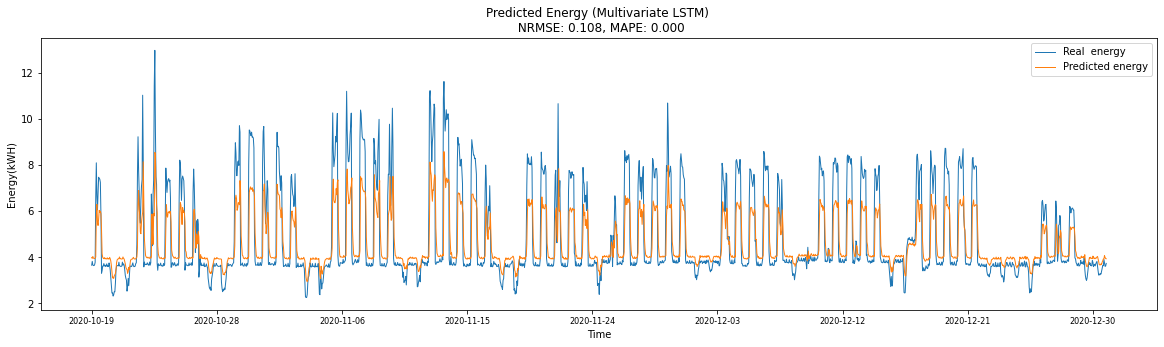

In [8]:
Predicted_energy, NRMSE, MAPE = Forecast_LSTM(LSTM_model, test_X, test_y, scaler, n_steps)